In [2]:
# Bibliotecas Basicas
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import janitor
import re
import ipywidgets as widgets
from IPython.display import display
import warnings

#Time Series Forecasting
from darts import TimeSeries
from darts.utils.statistics import plot_acf, check_seasonality, plot_residuals_analysis, extract_trend_and_seasonality
from darts.dataprocessing.transformers import Scaler, BoxCox, WindowTransformer
from sklearn.preprocessing import MinMaxScaler , RobustScaler, StandardScaler
from sklearn.metrics import mean_absolute_error
from darts.metrics import mape, mae
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode


#Models
#from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from darts.models import NHiTSModel
from darts.models import AutoARIMA
from darts.models import ExponentialSmoothing
from darts.models import TiDEModel
from darts.models import LightGBMModel
from darts.models import NLinearModel
from darts.models import DLinearModel
from darts.models import FourTheta
from darts.models import Prophet
from darts.models import Croston
#from darts.models import TSMixerModel
from darts.models import LightGBMModel
from darts.models import NaiveEnsembleModel
import lightgbm
import prophet

#torch
import torch
from chronos import ChronosPipeline


sns.set_style('whitegrid')
sns.set_palette('cubehelix')
warnings.filterwarnings("ignore")

c:\Users\PedroDiniz\miniconda3\Lib\site-packages\lightning_fabric\__init__.py:41: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
c:\Users\PedroDiniz\miniconda3\Lib\site-packages\pytorch_lightning\__init__.py:37: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
c:\Users\PedroDiniz\miniconda3\Lib\site-packages\fs\__init__.py:4: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('fs')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`.

## Import dos Dados

In [4]:
df = pd.read_csv('../data/02.intermediate/forms_results.csv', sep=';', decimal=',')
df = df[['date', 'controle_sobre_tempo', 'impacto_realizacao_pessoal']].copy()
df

date  controle_sobre_tempo  impacto_realizacao_pessoal
0    2023-01-01                  2.75                    2.166667
1    2023-01-02                  3.00                    2.500000
2    2023-01-03                  3.00                    2.833333
3    2023-01-04                  2.25                    2.000000
4    2023-01-05                  1.50                    2.666667
..          ...                   ...                         ...
573  2024-07-27                  1.25                    2.833333
574  2024-07-28                  1.50                    2.666667
575  2024-07-29                  2.00                    3.000000
576  2024-07-30                  1.75                    2.833333
577  2024-07-31                  3.00                    2.166667

[578 rows x 3 columns]

### Plot da Série de Controle Sobre o Tempo

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


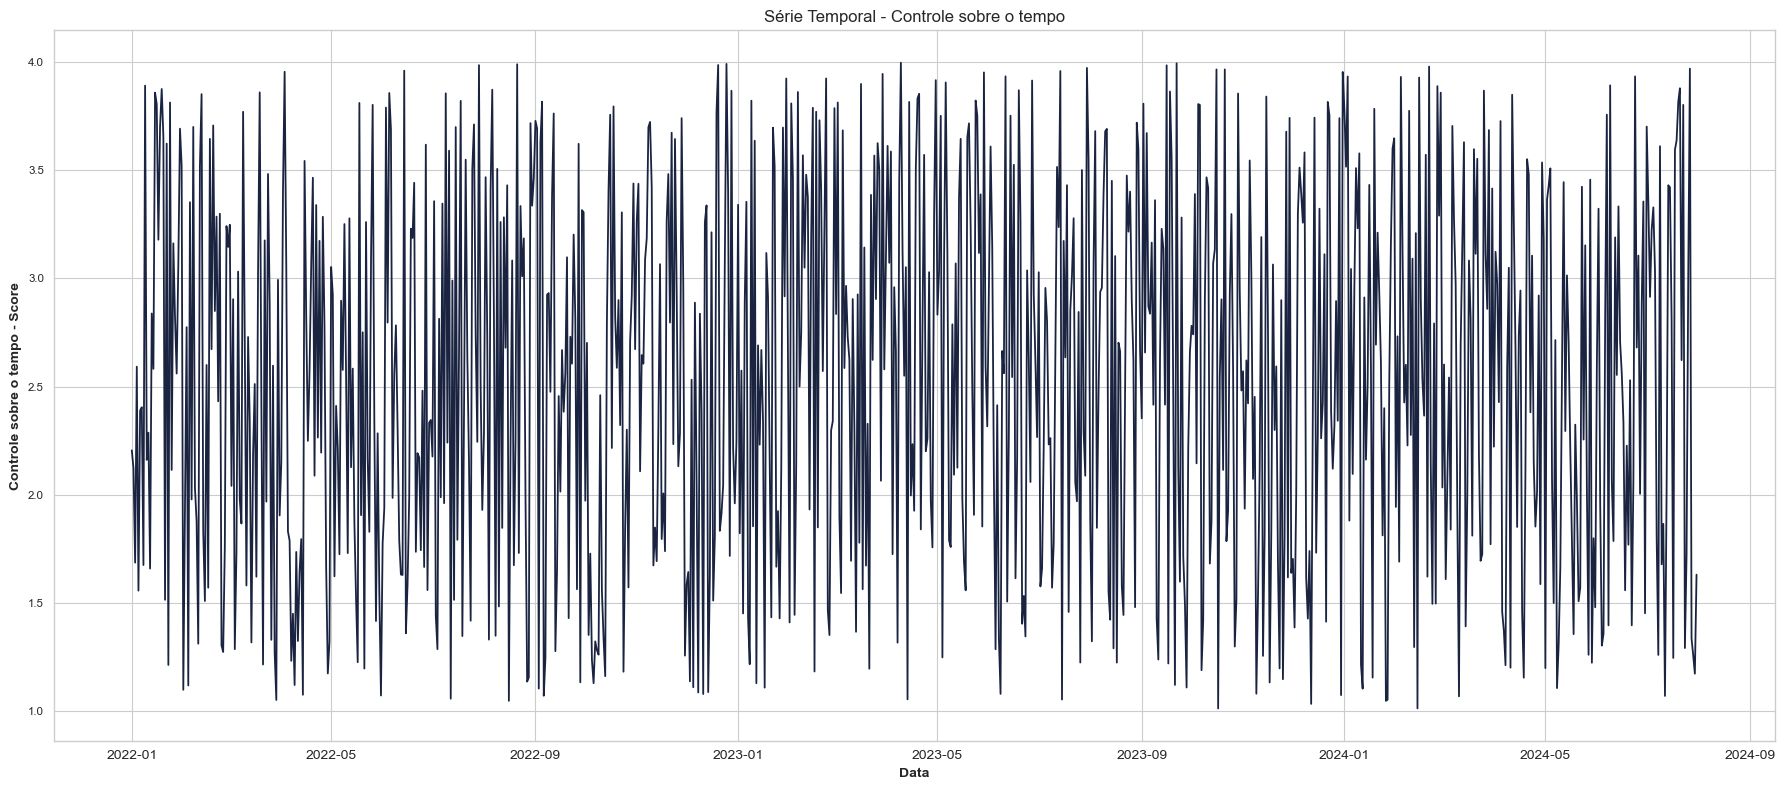

In [3]:
# Plot serie - Controle sobre o tempo
plt.figure(figsize=(18,8))
plt.title('Série Temporal - Controle sobre o tempo')
sns.lineplot(
    x=pd.to_datetime(df['date']),
    y='controle_sobre_tempo',
    data=df
)
plt.ylabel('Controle sobre o tempo - Score')
plt.xlabel('Data')
plt.xticks(fontsize= 10)  # Definindo o tamanho dos rótulos do eixo x
plt.tight_layout()
plt.legend()
plt.show()

### Plot da Série de Impacto e Realização Pessoal

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


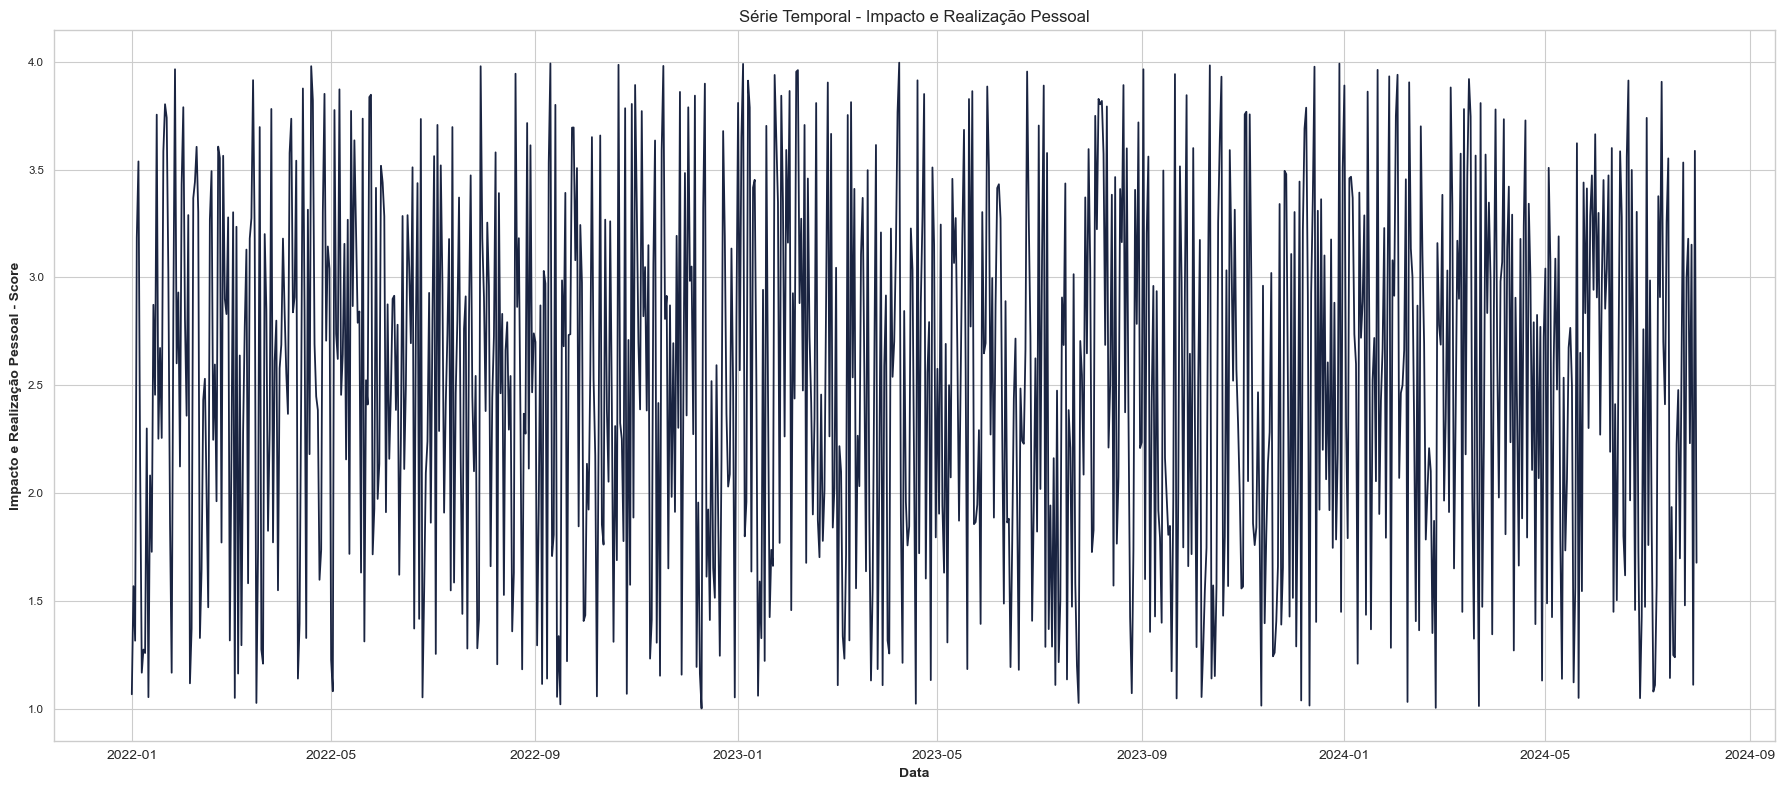

In [4]:
# Plot serie - Controle sobre o tempo
plt.figure(figsize=(18,8))
plt.title('Série Temporal - Impacto e Realização Pessoal')
sns.lineplot(
    x=pd.to_datetime(df['date']),
    y='impacto_realizacao_pessoal',
    data=df
)
plt.ylabel('Impacto e Realização Pessoal - Score')
plt.xlabel('Data')
plt.xticks(fontsize= 10)  # Definindo o tamanho dos rótulos do eixo x
plt.tight_layout()
plt.legend()
plt.show()

## Funções Necessárias

In [5]:
def preprocessing_time_series(time_series,metric): 

    #min_max =   MinMaxScaler(feature_range= (0,1))
    #transformer = Scaler(min_max)
    #time_series_adj = transformer.fit_transform(time_series)
    time_series_adj = time_series

    #features calculadas
    ts_df = time_series_adj.pd_dataframe().reset_index()
    ts_df['rolling_score'] = ts_df[metric].rolling(16).mean()
    ts_df['rolling_score_long'] = ts_df[metric].rolling(32).mean()
    ts_df['rolling_score_std'] = ts_df[metric].rolling(16).std()
    ts_df['rolling_score_long'] = ts_df[metric].rolling(32).std()
    ts_df = ts_df.fillna(0).replace([-np.inf, np.inf], 0)


    #features de tempo 
    time_series_adj = TimeSeries.from_dataframe(ts_df, time_col= 'date')
    time_series_adj = time_series_adj.add_holidays("BR")
    time_series_adj = time_series_adj.add_datetime_attribute("quarter", cyclic= True)
    time_series_adj = time_series_adj.add_datetime_attribute("month", cyclic  = True)
    time_series_adj = time_series_adj.add_datetime_attribute("day_of_week", cyclic  = True)
    time_series_adj = time_series_adj.add_datetime_attribute("day_of_year", cyclic  = True)
    time_series_adj = time_series_adj.add_datetime_attribute("week_of_year", cyclic  = True)
    time_series_adj = time_series_adj.add_datetime_attribute('year', cyclic= False)
    time_series_adj = time_series_adj.add_datetime_attribute('is_year_end')
    time_series_adj = time_series_adj.add_datetime_attribute("is_month_start")
    time_series_adj = time_series_adj.add_datetime_attribute("is_month_end")
    time_series_adj = time_series_adj.add_datetime_attribute("weekday", cyclic  = True)

    return time_series_adj #, transformer

In [6]:
def generate_cols_2_drop(timeseries, metric):
    target = metric
    cols_2_drop = timeseries.pd_dataframe()
    cols_2_drop = list(cols_2_drop.drop(columns = target).columns)

    return cols_2_drop

In [7]:

def evaluate_models(models, train, test, past_cov_train, past_cov_test ,cols_2_drop,title_name):

    best_model_dict = {}

    # Definindo subplot
    fig, axs = plt.subplots(len(models), 1, figsize=(14, 17))

    # Iterando sobre os modelos
    for i, (name, model) in enumerate(models.items()):

        # Treinando o modelo
        target = train.drop_columns(cols_2_drop)


        try:
                 
            model.fit(target, past_covariates= past_cov_train) #past_covariates= past_cov

            # Realizando previsões
            y_pred = model.predict(n=len(test), past_covariates= past_cov_train) #past_covariates= past_cov

        except:

            model.fit(target)
                    
            # Realizando previsões
            y_pred = model.predict(n=len(test))



        #Df dos dados
        train_df = train.pd_dataframe()
        test_df = test.pd_dataframe()
        pred_df = y_pred.pd_dataframe()
        
        # train_df['leitos_ocupados_totais'] = rescale_column(train_df, scaler, 'leitos_ocupados_totais')
        # test_df['leitos_ocupados_totais'] = rescale_column(test_df, scaler, 'leitos_ocupados_totais')
        # pred_df['leitos_ocupados_totais'] = rescale_column(pred_df, scaler, 'leitos_ocupados_totais')
    
        # Calculando o erro quadrático médio
        mae_score = mean_absolute_error(test_df[title_name].values, pred_df[title_name].values)
        mae_score = np.round(mae_score,4)

        best_model_dict[mae_score] = name


        # Plotando série histórica preditiva versus série histórica estimada
        axs[i].plot(train_df[title_name], label='Série Histórica Treino')
        axs[i].plot(test_df[title_name], label='Série Histórica Teste')
        axs[i].plot(pred_df[title_name], label=f'Série Histórica Estimada (MSE={mae_score:.2f})')
        #axs[i].axhline(y=15, color='red', linestyle='dotted')
        axs[i].set_title(f'Modelo: {name}')
        axs[i].legend(loc='lower left', fontsize='small', facecolor='white')

    # Adicionando título e legendas aos gráficos
    fig.suptitle(f'Serie Temporal: {title_name}', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return best_model_dict

## Modelo Preditivo - Controle Sobre o Tempo

In [8]:
split_prop = 0.885
train_loc = int(df.shape[0] * split_prop) 
test_loc =  df.shape[0] - train_loc

ts = df.set_index('date')[['controle_sobre_tempo']]
ts_train = ts.iloc[:train_loc,:] 
ts_test = ts.iloc[train_loc:, :]

ts_train = ts_train.reset_index()
ts_test = ts_test.reset_index()

print(ts_train.tail(10))
print("----------------------------------------")
print(ts_test.head(10))

           date  controle_sobre_tempo
824  2024-04-04              3.728400
825  2024-04-05              1.456684
826  2024-04-06              1.370911
827  2024-04-07              1.210192
828  2024-04-08              2.587125
829  2024-04-09              3.049507
830  2024-04-10              1.198756
831  2024-04-11              3.850170
832  2024-04-12              3.271801
833  2024-04-13              2.676401
----------------------------------------
         date  controle_sobre_tempo
0  2024-04-14              1.850027
1  2024-04-15              2.736270
2  2024-04-16              2.944114
3  2024-04-17              1.456888
4  2024-04-18              1.152512
5  2024-04-19              2.113491
6  2024-04-20              3.552090
7  2024-04-21              3.481939
8  2024-04-22              2.380577
9  2024-04-23              3.105653


In [9]:
print(
    "-------------------------------------",
    '\n',
    f"Dados de treinamento: {ts_train.shape[0]}",
    '\n',
    f"Dados de Teste: {ts_test.shape[0]}",
    '\n',
    "--------------------------------------"
)

------------------------------------- 
 Dados de treinamento: 834 
 Dados de Teste: 109 
 --------------------------------------


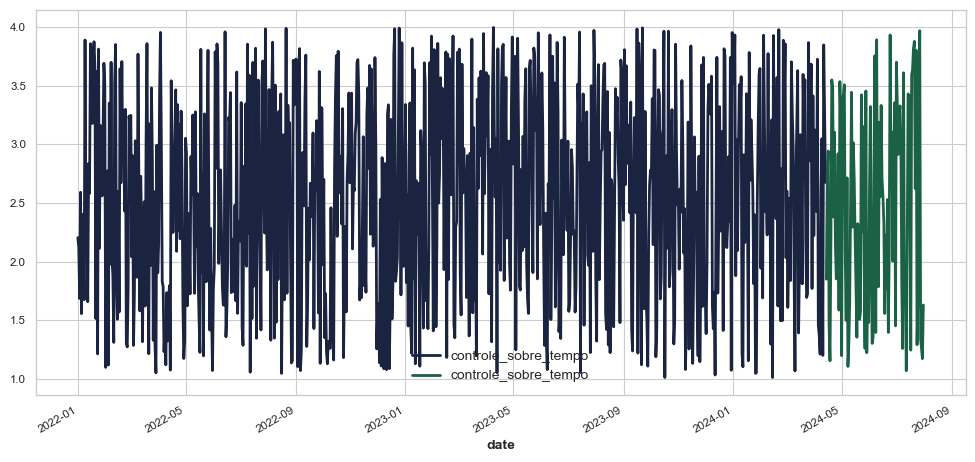

In [10]:
#Timeseries Object
ts_darts_train = TimeSeries.from_dataframe(ts_train, time_col  = 'date', value_cols= 'controle_sobre_tempo')
ts_darts_test = TimeSeries.from_dataframe(ts_test, time_col  = 'date', value_cols= 'controle_sobre_tempo')

#Figure Plot
plt.figure(figsize= (12,5))
ts_darts_train.plot()
ts_darts_test.plot()
plt.legend()
plt.show()

In [11]:
#Check de Sazonalidade
seasonal_order = []
for m in range(2, 61):
    is_seasonal, period = check_seasonality(ts_darts_train, m=m, max_lag= 61, alpha=0.05)
    if is_seasonal:
        seasonal_order.append(period)
        print("There is seasonality of order {}.".format(period))


There is seasonality of order 4.
There is seasonality of order 7.
There is seasonality of order 9.
There is seasonality of order 11.
There is seasonality of order 15.
There is seasonality of order 18.
There is seasonality of order 21.
There is seasonality of order 24.
There is seasonality of order 27.
There is seasonality of order 31.
There is seasonality of order 33.
There is seasonality of order 35.
There is seasonality of order 37.
There is seasonality of order 40.
There is seasonality of order 45.
There is seasonality of order 48.
There is seasonality of order 53.
There is seasonality of order 56.
There is seasonality of order 59.


### Teste do Darts

In [12]:
#Preprocessing
ts_darts_train = preprocessing_time_series(ts_darts_train,'controle_sobre_tempo')
ts_darts_test = preprocessing_time_series(ts_darts_test,'controle_sobre_tempo')

In [13]:
cols_2_drop = generate_cols_2_drop(ts_darts_train,'controle_sobre_tempo')
cols_2_drop

['rolling_score',
 'rolling_score_long',
 'rolling_score_std',
 'holidays',
 'quarter_sin',
 'quarter_cos',
 'month_sin',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_of_year_sin',
 'day_of_year_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'year',
 'is_year_end',
 'is_month_start',
 'is_month_end',
 'weekday_sin',
 'weekday_cos']

In [14]:
#Past Covariates
past_covariates_train = ts_darts_train.drop_columns('controle_sobre_tempo')
past_covariates_test = ts_darts_test.drop_columns('controle_sobre_tempo')

In [15]:

# Inicializando modelos
try:
    seasonal_array = np.array(seasonal_order)
    try:
        season_value = seasonal_array[(seasonal_array >= 20) & (seasonal_array < 30)][0]
    except:
        try:
            season_value = seasonal_array[(seasonal_array >= 15) & (seasonal_array < 35)][0]
        except:
            season_value = seasonal_array[-1]
except:
    season_value =  60

#Early Stopper
my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=10,
    min_delta=0.05,
    mode='min',
)

global_params = {
    'output_chunk': len(ts_darts_test),
    'input_chunk': int(season_value),
     'epocas': 10
}



models = {

    "N-Hits": NHiTSModel(input_chunk_length = global_params['input_chunk'],
                        output_chunk_length =  global_params['output_chunk'],
                        n_epochs  = global_params['epocas'],
                        num_layers = 3,
                        layer_widths = 128, 
                        num_stacks = 2,
                        num_blocks = 1,
                        loss_fn = torch.nn.MSELoss(),
                        random_state = 42, 
                        ),
                        
     "N-Linear": NLinearModel(input_chunk_length = global_params['input_chunk'],
                         output_chunk_length =  global_params['output_chunk'],
                         n_epochs  = global_params['epocas'],
                         loss_fn = torch.nn.MSELoss(),
                         random_state = 42,
                         ),

     "TiDe": TiDEModel(input_chunk_length = global_params['input_chunk'],
                         output_chunk_length =  global_params['output_chunk'],
                         n_epochs  = global_params['epocas'],
                         ),
                        
     "D-linear": DLinearModel(input_chunk_length = global_params['input_chunk'],
                         output_chunk_length =  global_params['output_chunk'],
                         n_epochs  = global_params['epocas'],
                         loss_fn =torch.nn.MSELoss(),
                         random_state = 42),
                        
    "Exponencial": ExponentialSmoothing(random_state = 42,
                                         seasonal_periods = 7,
                                        trend=ModelMode.ADDITIVE,
                                        seasonal=SeasonalityMode.ADDITIVE),
                                        
    "Theta": FourTheta(trend_mode= TrendMode.EXPONENTIAL,
                       theta  = 4,
                       seasonality_period  = int(season_value),
                        season_mode= SeasonalityMode.ADDITIVE),

    "Ensembled": NaiveEnsembleModel([
        NHiTSModel(input_chunk_length = global_params['input_chunk'],
                        output_chunk_length =  global_params['output_chunk'],
                        n_epochs  = global_params['epocas'],
                        num_layers = 3,
                        layer_widths = 256, 
                        num_stacks = 2,
                        num_blocks = 1,
                        loss_fn = torch.nn.MSELoss(),
                        random_state = 42, 
                        ),         
        ExponentialSmoothing(random_state = 42,
                            seasonal_periods = int(season_value),
                            trend=ModelMode.ADDITIVE,
                            seasonal=SeasonalityMode.ADDITIVE),    
        ])          

}


Some `forecasting_models` in the ensemble do not support past covariates, the past covariates will be provided only to the models supporting them when calling fit()` or `predict()`. To hide these warnings, set `show_warnings=False`.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 487 K 
---------------------------------------------------
430 K     Trainable params
56.9 K    Non-trainable params
487 K     Total params
1.949     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 48.2 K
---------------------------------------------------
48.2 K    Trainable params
0         Non-trainable params
48.2 K    Total params
0.193     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params
---------------------------------------------------------
0 | criterion           | MSELoss          | 0     
1 | train_metrics       | MetricCollection | 0     
2 | val_metrics         | MetricCollection | 0     
3 | past_cov_projection | _ResidualBlock   | 3.3 K 
4 | encoders            | Sequential       | 43.6 K
5 | decoders            | Sequential       | 466 K 
6 | temporal_decoder    | _ResidualBlock   | 594   
7 | lookback_skip       | Linear           | 2.4 K 
---------------------------------------------------------
516 K     Trainable params
0         Non-trainable params
516 K     Total params
2.066     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 48.2 K
5 | linear_trend    | Linear           | 48.2 K
-----------------------------------------------------
96.4 K    Trainable params
0         Non-trainable params
96.4 K    Total params
0.385     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.1 M 
---------------------------------------------------
989 K     Trainable params
113 K     Non-trainable params
1.1 M     Total params
4.410     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

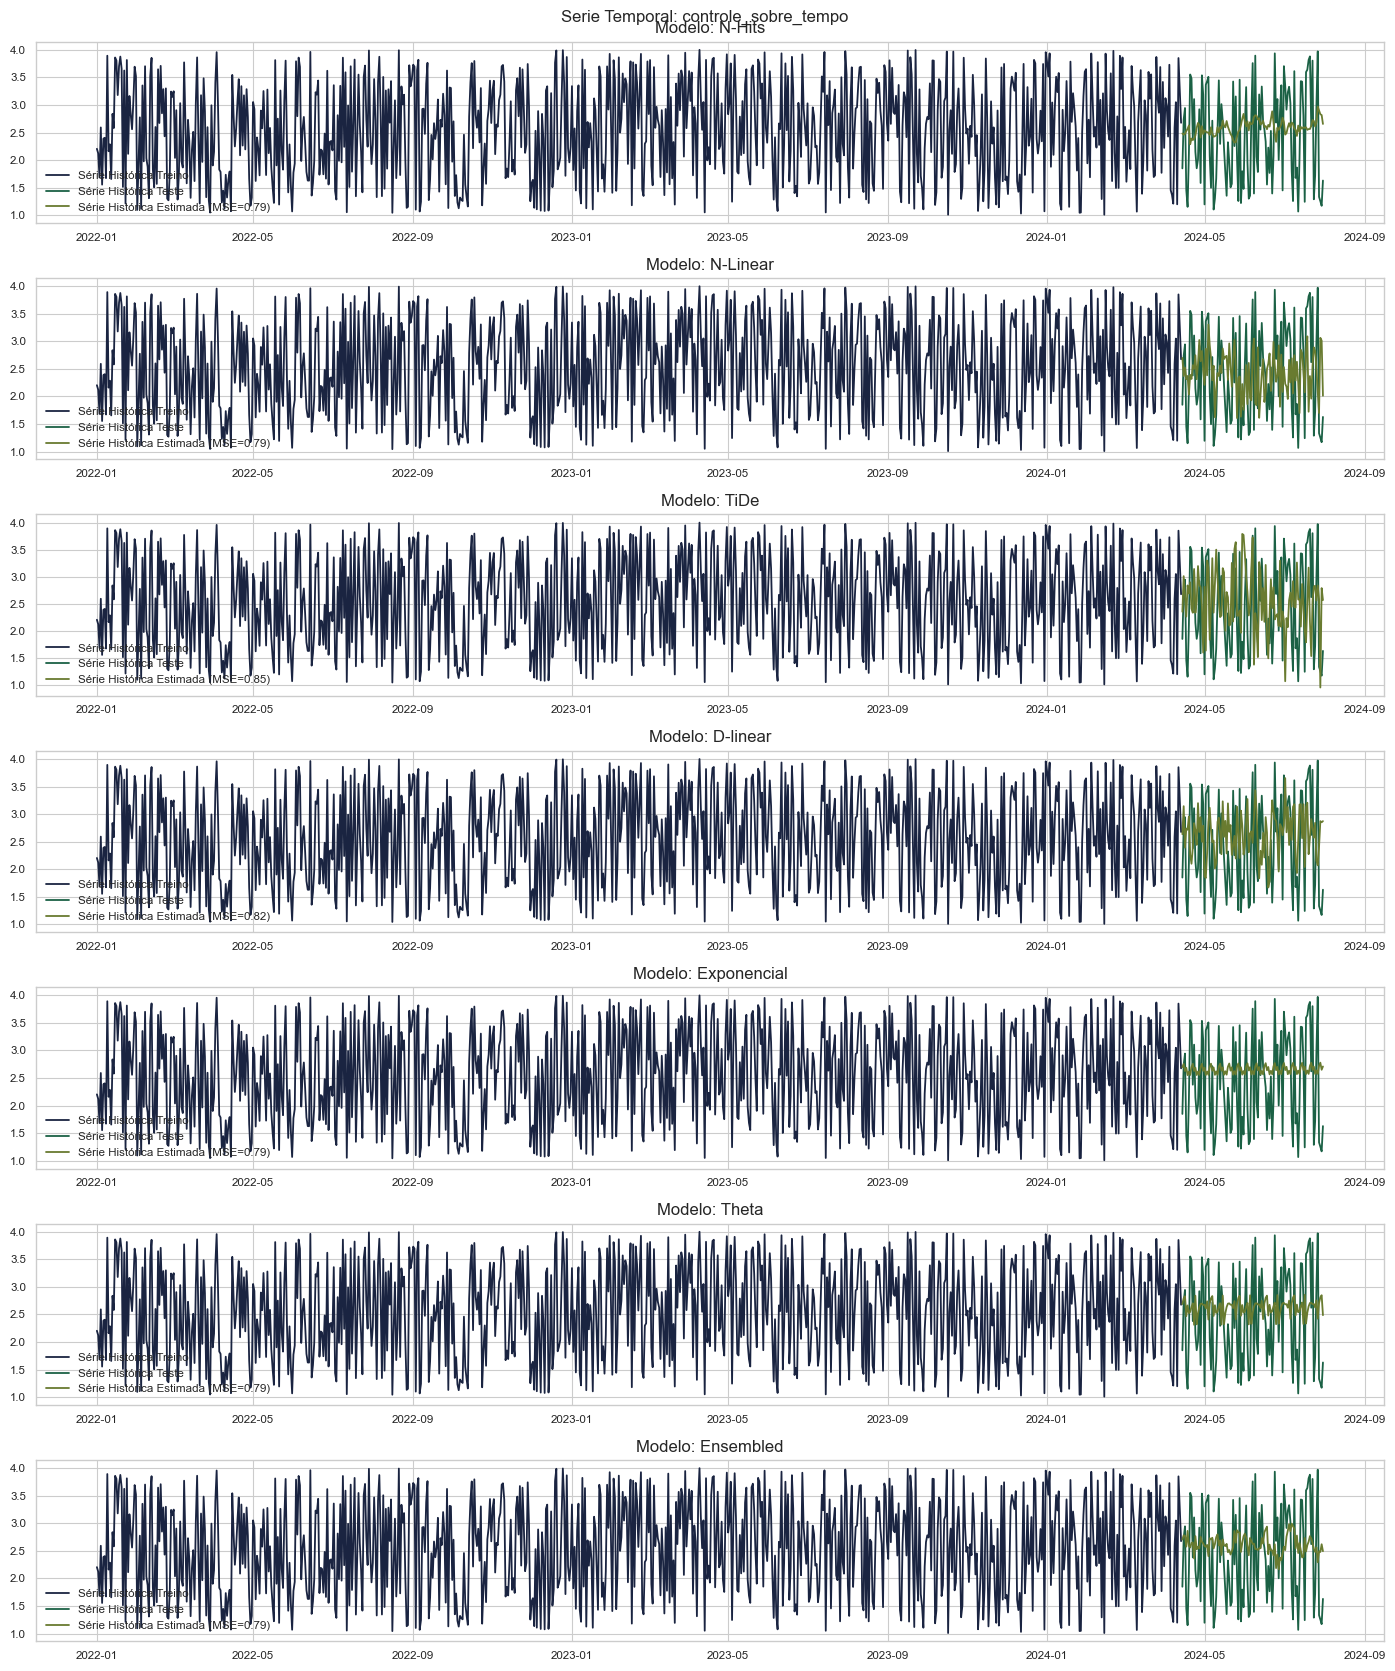

In [16]:
#Train, Test and plot

best_model_dict = evaluate_models(models,
                                ts_darts_train,
                                ts_darts_test,
                                past_covariates_train,
                                past_covariates_test,
                                cols_2_drop,
                                'controle_sobre_tempo'
                                )


### Teste do Amazon Chronos

In [17]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

In [18]:
pred_len = len(ts_test)
contexto = torch.tensor(ts_train['controle_sobre_tempo'])
forecast = pipeline.predict(
    context= contexto,
    prediction_length= pred_len,
    num_samples= 15,
    limit_prediction_length = False,
)

In [19]:
fc_index = pd.date_range(start=pd.to_datetime(ts_train.date.iloc[-1]) + pd.Timedelta(days=1), periods= pred_len, freq='D')
fc_index


DatetimeIndex(['2024-04-14', '2024-04-15', '2024-04-16', '2024-04-17',
               '2024-04-18', '2024-04-19', '2024-04-20', '2024-04-21',
               '2024-04-22', '2024-04-23',
               ...
               '2024-07-22', '2024-07-23', '2024-07-24', '2024-07-25',
               '2024-07-26', '2024-07-27', '2024-07-28', '2024-07-29',
               '2024-07-30', '2024-07-31'],
              dtype='datetime64[ns]', length=109, freq='D')

In [20]:
low, median, high = np.quantile(forecast[0].numpy(), [0.10, 0.5, 0.90], axis=0)
mean_pred = np.mean(forecast[0].numpy(), axis = 0)

y_pred = pd.DataFrame(data= mean_pred,
                     index=fc_index).rename(columns= {0:'controle_sobre_tempo'})

y_pred['10_percentile'] = low
y_pred['90_percentile'] = high

y_pred

controle_sobre_tempo  10_percentile  90_percentile
2024-04-14              2.596699       2.041990       3.053443
2024-04-15              2.729015       2.209929       3.064894
2024-04-16              2.769728       2.175579       3.366421
2024-04-17              2.807896       2.412220       3.114512
2024-04-18              2.779906       2.469472       3.045810
...                          ...            ...            ...
2024-07-27              2.890958       2.767524       3.013093
2024-07-28              2.801306       2.588220       2.935135
2024-07-29              2.857176       2.627199       2.997501
2024-07-30              2.963719       2.829891       3.114439
2024-07-31              2.827292       2.584321       3.032582

[109 rows x 3 columns]

In [21]:
#inverse transform das series

ts_train_adj = ts_train.copy()
ts_train_adj = ts_train_adj.set_index("date")


ts_test_adj = ts_test.copy()
ts_test_adj = ts_test_adj.set_index("date")


In [22]:
#Calculo das métricas de erro 

erro  = mean_absolute_error(ts_test_adj['controle_sobre_tempo'].values,
                             y_pred['controle_sobre_tempo'].values)
erro = np.round(erro, 2)

print(
    "------------------------------------",
    '\n',
    f"Erro de predição: {erro} do score em média",
    '\n',
    "------------------------------------",
)

------------------------------------ 
 Erro de predição: 0.82 do score em média 
 ------------------------------------


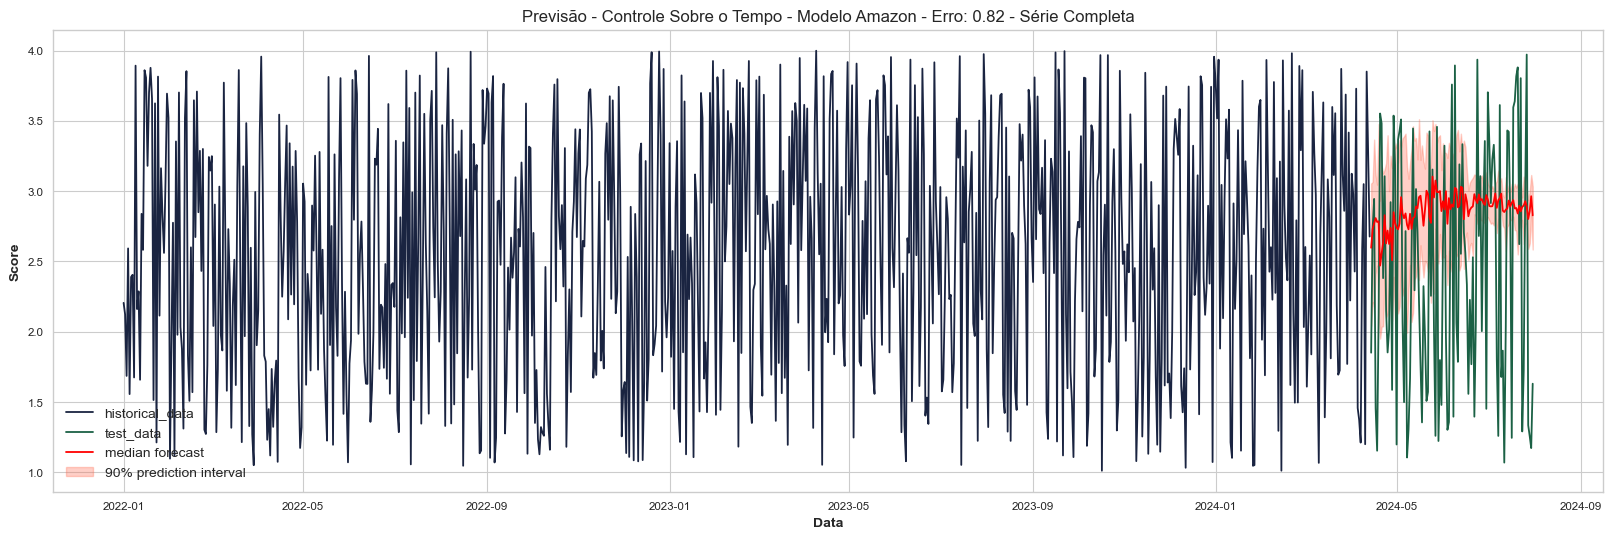

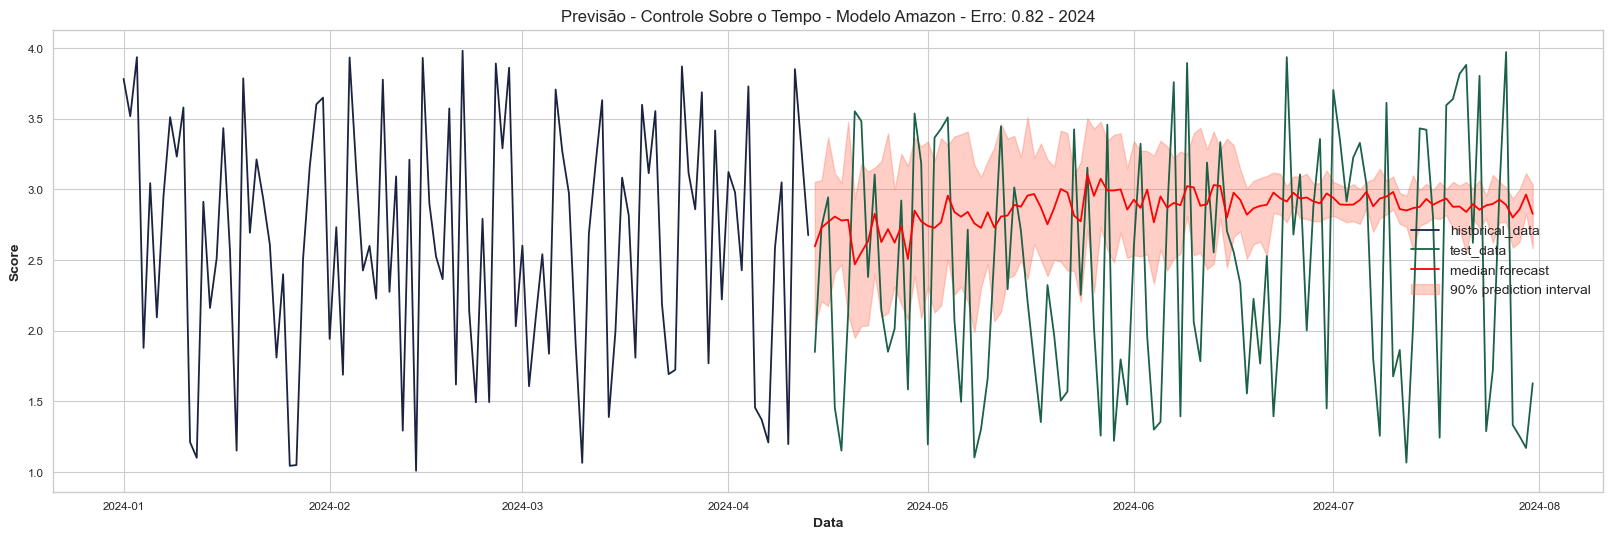

In [23]:
y_pred_adj = y_pred
y_pred_adj['date'] = pd.to_datetime(y_pred_adj.index)
y_pred_adj.rename(columns={'controle_sobre_tempo':'controle_sobre_tempo_pred'}, inplace=True)

ts_train_adj['label'] = 'historical_data'
ts_test_adj['label'] = 'test_data'

ts_full = pd.concat([ts_train_adj,ts_test_adj]).reset_index()
ts_full['date'] = pd.to_datetime(ts_full['date'])

df_plot = ts_full.merge(y_pred_adj, left_on='date', right_on='date', how='left')

plt.figure(figsize=(20,6))
plt.title(f"Previsão - Controle Sobre o Tempo - Modelo Amazon - Erro: {erro} - Série Completa")
sns.lineplot(x='date', y='controle_sobre_tempo', hue='label', data=df_plot)
sns.lineplot(x='date', y='controle_sobre_tempo_pred', color="red", label="median forecast", data=df_plot)
plt.fill_between(df_plot['date'], df_plot['10_percentile'], df_plot['90_percentile'], color="tomato", alpha=0.3, label="90% prediction interval")
plt.ylabel("Score")
plt.xlabel("Data")
plt.legend()
plt.grid(visible= True)
plt.show()

df_plot = df_plot[df_plot.date.dt.year==2024].copy()

plt.figure(figsize=(20,6))
plt.title(f"Previsão - Controle Sobre o Tempo - Modelo Amazon - Erro: {erro} - 2024")
sns.lineplot(x='date', y='controle_sobre_tempo', hue='label', data=df_plot)
sns.lineplot(x='date', y='controle_sobre_tempo_pred', color="red", label="median forecast", data=df_plot)
plt.fill_between(df_plot['date'], df_plot['10_percentile'], df_plot['90_percentile'], color="tomato", alpha=0.3, label="90% prediction interval")
plt.ylabel("Score")
plt.xlabel("Data")
plt.legend()
plt.grid(visible= True)
plt.show()

del df_plot
del ts_full

## Modelo Preditivo - Impacto e Realização Pessoal

In [24]:
split_prop = 0.885
train_loc = int(df.shape[0] * split_prop) 
test_loc =  df.shape[0] - train_loc

ts = df.set_index('date')[['impacto_realizacao_pessoal']]
ts_train = ts.iloc[:train_loc,:] 
ts_test = ts.iloc[train_loc:, :]

ts_train = ts_train.reset_index()
ts_test = ts_test.reset_index()

print(ts_train.tail(10))
print("----------------------------------------")
print(ts_test.head(10))

           date  impacto_realizacao_pessoal
824  2024-04-04                    2.981727
825  2024-04-05                    3.071958
826  2024-04-06                    3.734108
827  2024-04-07                    1.809115
828  2024-04-08                    3.131226
829  2024-04-09                    3.421521
830  2024-04-10                    2.235802
831  2024-04-11                    3.291390
832  2024-04-12                    1.269972
833  2024-04-13                    2.906104
----------------------------------------
         date  impacto_realizacao_pessoal
0  2024-04-14                    2.359095
1  2024-04-15                    1.663760
2  2024-04-16                    3.178878
3  2024-04-17                    1.882880
4  2024-04-18                    3.238642
5  2024-04-19                    3.728562
6  2024-04-20                    1.794039
7  2024-04-21                    3.342176
8  2024-04-22                    3.001217
9  2024-04-23                    2.107235


In [25]:
print(
    "-------------------------------------",
    '\n',
    f"Dados de treinamento: {ts_train.shape[0]}",
    '\n',
    f"Dados de Teste: {ts_test.shape[0]}",
    '\n',
    "--------------------------------------"
)

------------------------------------- 
 Dados de treinamento: 834 
 Dados de Teste: 109 
 --------------------------------------


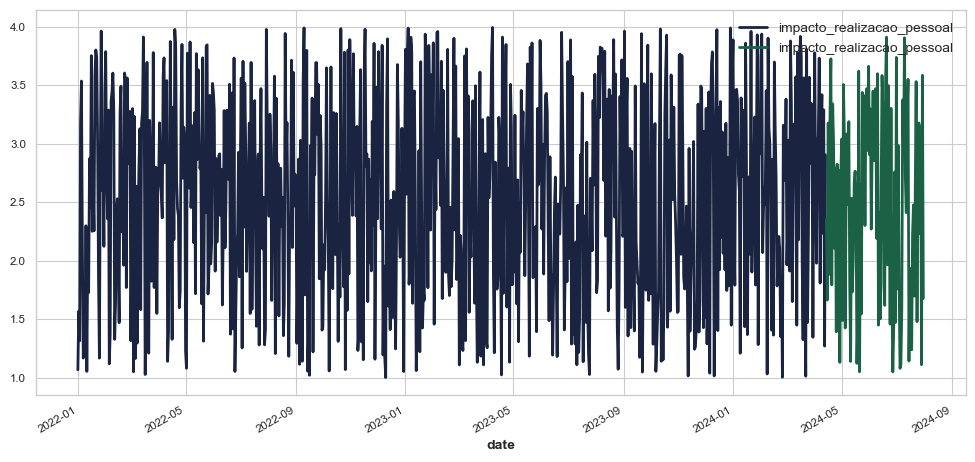

In [26]:
#Timeseries Object
ts_darts_train = TimeSeries.from_dataframe(ts_train, time_col  = 'date', value_cols= 'impacto_realizacao_pessoal')
ts_darts_test = TimeSeries.from_dataframe(ts_test, time_col  = 'date', value_cols= 'impacto_realizacao_pessoal')

#Figure Plot
plt.figure(figsize= (12,5))
ts_darts_train.plot()
ts_darts_test.plot()
plt.legend()
plt.show()

In [27]:
#Check de Sazonalidade
seasonal_order = []
for m in range(2, 61):
    is_seasonal, period = check_seasonality(ts_darts_train, m=m, max_lag= 61, alpha=0.05)
    if is_seasonal:
        seasonal_order.append(period)
        print("There is seasonality of order {}.".format(period))


There is seasonality of order 3.
There is seasonality of order 5.
There is seasonality of order 7.
There is seasonality of order 12.
There is seasonality of order 17.
There is seasonality of order 19.
There is seasonality of order 22.
There is seasonality of order 27.
There is seasonality of order 30.
There is seasonality of order 33.
There is seasonality of order 35.
There is seasonality of order 39.
There is seasonality of order 42.
There is seasonality of order 44.
There is seasonality of order 52.
There is seasonality of order 56.
There is seasonality of order 59.


### Teste do Darts

In [28]:
#Preprocessing
ts_darts_train = preprocessing_time_series(ts_darts_train,'impacto_realizacao_pessoal')
ts_darts_test = preprocessing_time_series(ts_darts_test,'impacto_realizacao_pessoal')

In [29]:
cols_2_drop = generate_cols_2_drop(ts_darts_train,'impacto_realizacao_pessoal')
cols_2_drop

['rolling_score',
 'rolling_score_long',
 'rolling_score_std',
 'holidays',
 'quarter_sin',
 'quarter_cos',
 'month_sin',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_of_year_sin',
 'day_of_year_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'year',
 'is_year_end',
 'is_month_start',
 'is_month_end',
 'weekday_sin',
 'weekday_cos']

In [30]:
#Past Covariates
past_covariates_train = ts_darts_train.drop_columns('impacto_realizacao_pessoal')
past_covariates_test = ts_darts_test.drop_columns('impacto_realizacao_pessoal')

In [31]:

# Inicializando modelos
try:
    seasonal_array = np.array(seasonal_order)
    try:
        season_value = seasonal_array[(seasonal_array >= 20) & (seasonal_array < 30)][0]
    except:
        try:
            season_value = seasonal_array[(seasonal_array >= 15) & (seasonal_array < 35)][0]
        except:
            season_value = seasonal_array[-1]
except:
    season_value =  60

#Early Stopper
my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=10,
    min_delta=0.05,
    mode='min',
)

global_params = {
    'output_chunk': len(ts_darts_test),
    'input_chunk': int(season_value),
     'epocas': 10
}



models = {

    "N-Hits": NHiTSModel(input_chunk_length = global_params['input_chunk'],
                        output_chunk_length =  global_params['output_chunk'],
                        n_epochs  = global_params['epocas'],
                        num_layers = 3,
                        layer_widths = 128, 
                        num_stacks = 2,
                        num_blocks = 1,
                        loss_fn = torch.nn.MSELoss(),
                        random_state = 42, 
                        ),
                        
     "N-Linear": NLinearModel(input_chunk_length = global_params['input_chunk'],
                         output_chunk_length =  global_params['output_chunk'],
                         n_epochs  = global_params['epocas'],
                         loss_fn = torch.nn.MSELoss(),
                         random_state = 42,
                         ),

     "TiDe": TiDEModel(input_chunk_length = global_params['input_chunk'],
                         output_chunk_length =  global_params['output_chunk'],
                         n_epochs  = global_params['epocas'],
                         ),
                        
     "D-linear": DLinearModel(input_chunk_length = global_params['input_chunk'],
                         output_chunk_length =  global_params['output_chunk'],
                         n_epochs  = global_params['epocas'],
                         loss_fn =torch.nn.MSELoss(),
                         random_state = 42),
                        
    "Exponencial": ExponentialSmoothing(random_state = 42,
                                         seasonal_periods = 7,
                                        trend=ModelMode.ADDITIVE,
                                        seasonal=SeasonalityMode.ADDITIVE),
                                        
    "Theta": FourTheta(trend_mode= TrendMode.EXPONENTIAL,
                       theta  = 4,
                       seasonality_period  = int(season_value),
                        season_mode= SeasonalityMode.ADDITIVE),

    "Ensembled": NaiveEnsembleModel([
        NHiTSModel(input_chunk_length = global_params['input_chunk'],
                        output_chunk_length =  global_params['output_chunk'],
                        n_epochs  = global_params['epocas'],
                        num_layers = 3,
                        layer_widths = 256, 
                        num_stacks = 2,
                        num_blocks = 1,
                        loss_fn = torch.nn.MSELoss(),
                        random_state = 42, 
                        ),         
        ExponentialSmoothing(random_state = 42,
                            seasonal_periods = int(season_value),
                            trend=ModelMode.ADDITIVE,
                            seasonal=SeasonalityMode.ADDITIVE),    
        ])          

}


Some `forecasting_models` in the ensemble do not support past covariates, the past covariates will be provided only to the models supporting them when calling fit()` or `predict()`. To hide these warnings, set `show_warnings=False`.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 492 K 
---------------------------------------------------
432 K     Trainable params
59.6 K    Non-trainable params
492 K     Total params
1.969     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 50.5 K
---------------------------------------------------
50.5 K    Trainable params
0         Non-trainable params
50.5 K    Total params
0.202     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                | Type             | Params
---------------------------------------------------------
0 | criterion           | MSELoss          | 0     
1 | train_metrics       | MetricCollection | 0     
2 | val_metrics         | MetricCollection | 0     
3 | past_cov_projection | _ResidualBlock   | 3.3 K 
4 | encoders            | Sequential       | 44.9 K
5 | decoders            | Sequential       | 466 K 
6 | temporal_decoder    | _ResidualBlock   | 594   
7 | lookback_skip       | Linear           | 2.5 K 
---------------------------------------------------------
517 K     Trainable params
0         Non-trainable params
517 K     Total params
2.071     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 50.5 K
5 | linear_trend    | Linear           | 50.5 K
-----------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.404     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 1.1 M 
---------------------------------------------------
993 K     Trainable params
118 K     Non-trainable params
1.1 M     Total params
4.450     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

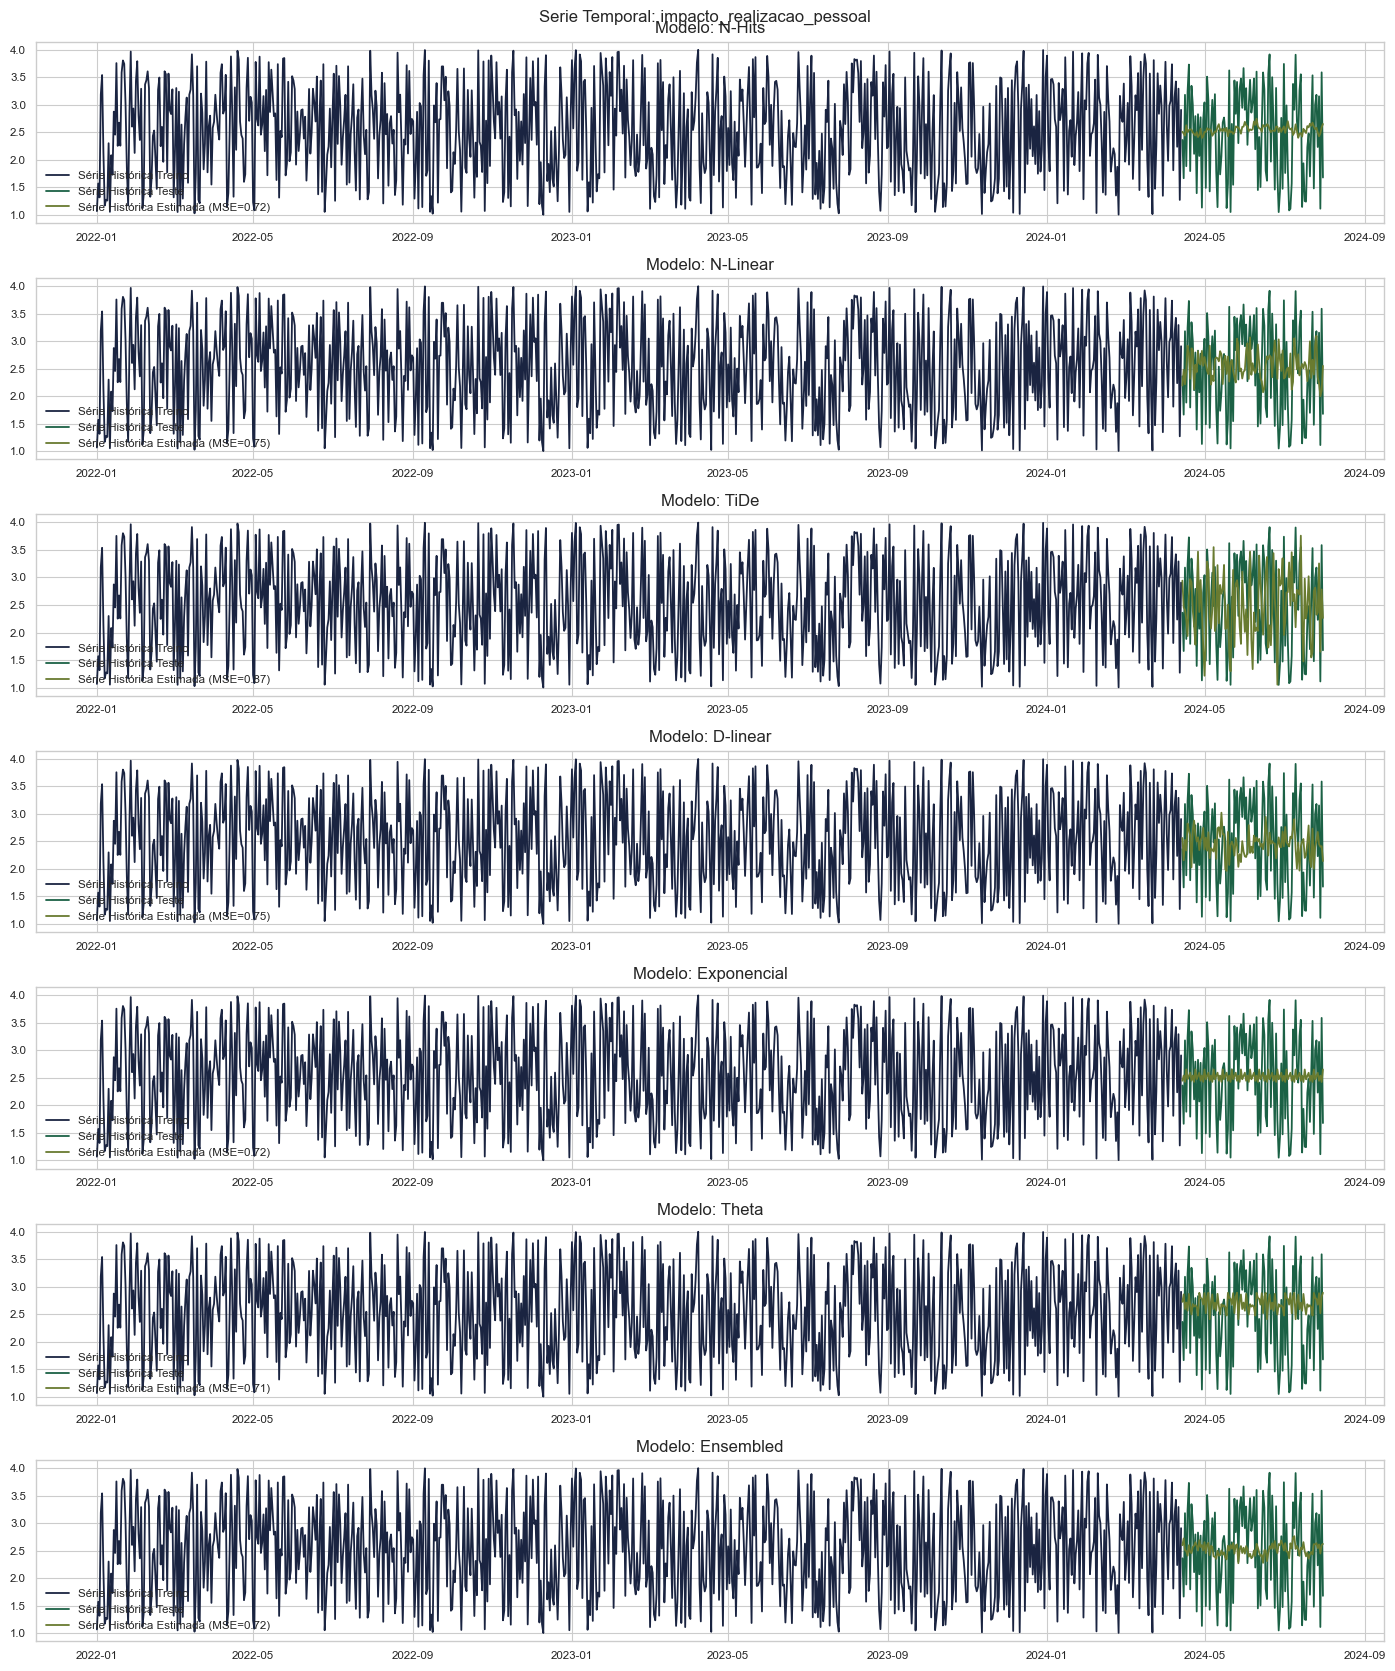

In [32]:
#Train, Test and plot

best_model_dict = evaluate_models(models,
                                ts_darts_train,
                                ts_darts_test,
                                past_covariates_train,
                                past_covariates_test,
                                cols_2_drop,
                                'impacto_realizacao_pessoal'
                                )


### Teste do Amazon Chronos

In [33]:
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-base",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

In [34]:
pred_len = len(ts_test)
contexto = torch.tensor(ts_train['impacto_realizacao_pessoal'])
forecast = pipeline.predict(
    context= contexto,
    prediction_length= pred_len,
    num_samples= 15,
    limit_prediction_length = False,
)

In [35]:
fc_index = pd.date_range(start=pd.to_datetime(ts_train.date.iloc[-1]) + pd.Timedelta(days=1), periods= pred_len, freq='D')
fc_index

DatetimeIndex(['2024-04-14', '2024-04-15', '2024-04-16', '2024-04-17',
               '2024-04-18', '2024-04-19', '2024-04-20', '2024-04-21',
               '2024-04-22', '2024-04-23',
               ...
               '2024-07-22', '2024-07-23', '2024-07-24', '2024-07-25',
               '2024-07-26', '2024-07-27', '2024-07-28', '2024-07-29',
               '2024-07-30', '2024-07-31'],
              dtype='datetime64[ns]', length=109, freq='D')

In [36]:
low, median, high = np.quantile(forecast[0].numpy(), [0.10, 0.5, 0.90], axis=0)
mean_pred = np.mean(forecast[0].numpy(), axis = 0)

y_pred = pd.DataFrame(data= mean_pred,
                     index=fc_index).rename(columns= {0:'impacto_realizacao_pessoal'})

y_pred['10_percentile'] = low
y_pred['90_percentile'] = high

y_pred

impacto_realizacao_pessoal  10_percentile  90_percentile
2024-04-14                    2.467102       1.838330       2.934683
2024-04-15                    2.388351       1.882626       2.820248
2024-04-16                    2.480637       1.974911       2.967905
2024-04-17                    2.555696       2.067197       3.056499
2024-04-18                    2.457258       1.963838       3.049116
...                                ...            ...            ...
2024-07-27                    2.388051       2.213704       2.548891
2024-07-28                    2.421201       2.280005       2.556259
2024-07-29                    2.438390       2.375772       2.515742
2024-07-30                    2.373317       2.206337       2.545209
2024-07-31                    2.331572       2.213704       2.467857

[109 rows x 3 columns]

In [37]:
#inverse transform das series

ts_train_adj = ts_train.copy()
ts_train_adj = ts_train_adj.set_index("date")


ts_test_adj = ts_test.copy()
ts_test_adj = ts_test_adj.set_index("date")


In [38]:
#Calculo das métricas de erro 

erro  = mean_absolute_error(ts_test_adj['impacto_realizacao_pessoal'].values,
                             y_pred['impacto_realizacao_pessoal'].values)
erro = np.round(erro, 2)

print(
    "------------------------------------",
    '\n',
    f"Erro de predição: {erro} do score em média",
    '\n',
    "------------------------------------",
)

------------------------------------ 
 Erro de predição: 0.74 do score em média 
 ------------------------------------


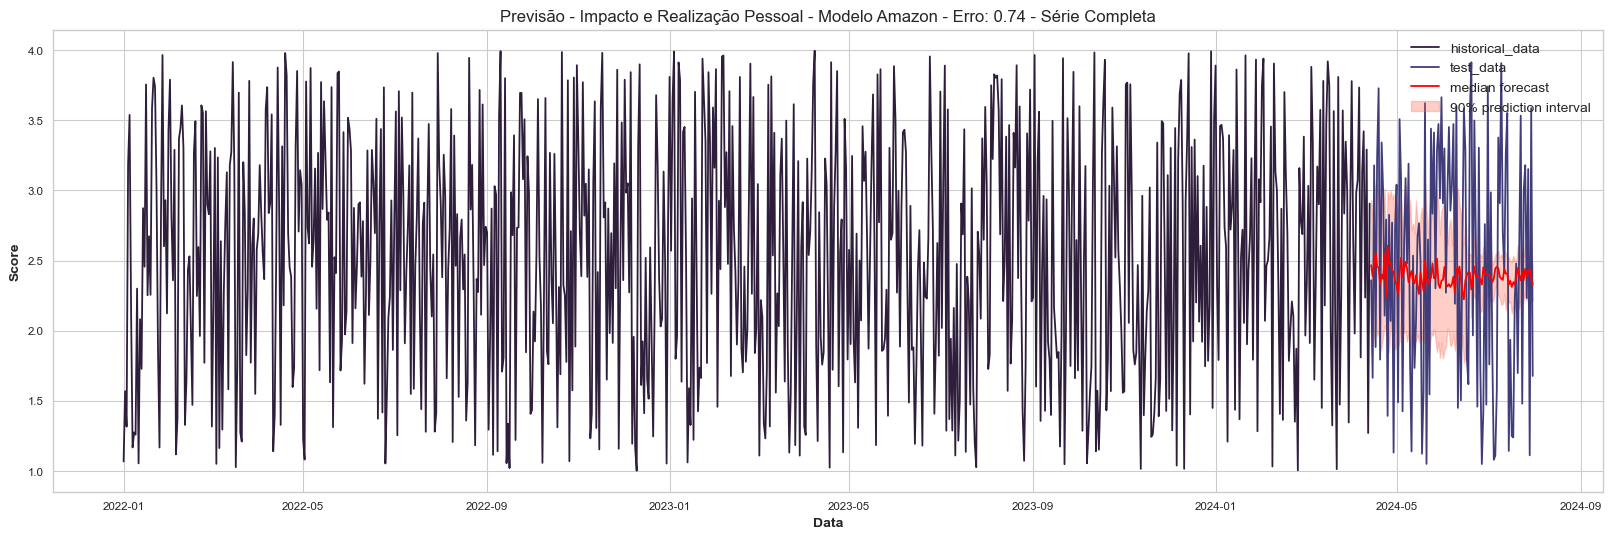

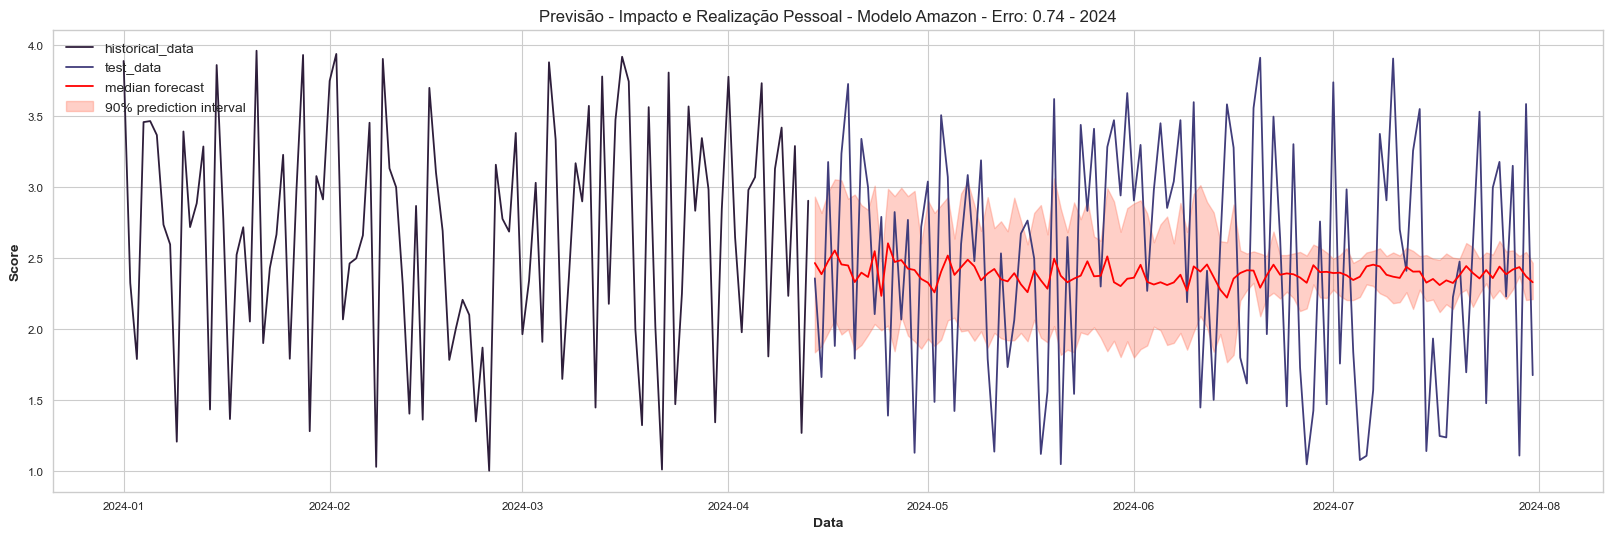

In [39]:
y_pred_adj = y_pred
y_pred_adj['date'] = pd.to_datetime(y_pred_adj.index)
y_pred_adj.rename(columns={'impacto_realizacao_pessoal':'impacto_realizacao_pessoal_pred'}, inplace=True)

ts_train_adj['label'] = 'historical_data'
ts_test_adj['label'] = 'test_data'

ts_full = pd.concat([ts_train_adj,ts_test_adj]).reset_index()
ts_full['date'] = pd.to_datetime(ts_full['date'])

df_plot = ts_full.merge(y_pred_adj, left_on='date', right_on='date', how='left')

plt.figure(figsize=(20,6))
sns.set_palette('mako')
plt.title(f"Previsão - Impacto e Realização Pessoal - Modelo Amazon - Erro: {erro} - Série Completa")
sns.lineplot(x='date', y='impacto_realizacao_pessoal', hue='label', data=df_plot)
sns.lineplot(x='date', y='impacto_realizacao_pessoal_pred', color="red", label="median forecast", data=df_plot)
plt.fill_between(df_plot['date'], df_plot['10_percentile'], df_plot['90_percentile'], color="tomato", alpha=0.3, label="90% prediction interval")
plt.ylabel("Score")
plt.xlabel("Data")
plt.legend()
plt.grid(visible= True)
plt.show()

df_plot = df_plot[df_plot.date.dt.year==2024].copy()

plt.figure(figsize=(20,6))
sns.set_palette('mako')
plt.title(f"Previsão - Impacto e Realização Pessoal - Modelo Amazon - Erro: {erro} - 2024")
sns.lineplot(x='date', y='impacto_realizacao_pessoal', hue='label', data=df_plot)
sns.lineplot(x='date', y='impacto_realizacao_pessoal_pred', color="red", label="median forecast", data=df_plot)
plt.fill_between(df_plot['date'], df_plot['10_percentile'], df_plot['90_percentile'], color="tomato", alpha=0.3, label="90% prediction interval")
plt.ylabel("Score")
plt.xlabel("Data")
plt.legend()
plt.grid(visible= True)
plt.show()

del df_plot
del ts_full